# Fly Hemibrain

Playing around with some basic connectome data, from the [Fly Hemibrain](https://www.janelia.org/project-team/flyem/hemibrain) project. If you scroll down that page a little, under the heading "Resources and relevant technologies", the first link "Compact connection matrix summary" is a zip file with three `.csv` files (and a useful README), those files need to be moved into the directory `/notebooks/hemibrain/exported-traced-adjacencies/` for this script. I didn't want to post those files to a public github repo since (a) they're not my data and (b) they're like, a few hundred megabytes in total.

In [1]:
"""Playing around with the fly hemibrain data"""

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import DrawingArea, OffsetImage, AnnotationBbox

import time

## Load the graph

In [2]:
# Step 1: Just reading some csv files and attempting to make a networkx graph

directory = "/notebooks/nx_graph_utils/hemibrain/exported-traced-adjacencies/"

print("Attempting to read files in directory", directory)

nodes_file = "traced-neurons.csv"
edges_file = "traced-total-connections.csv"

edge_data = open(directory+edges_file, "r")
next(edge_data, None)  # skip the first line of the file, which is just a header row

t_start = time.time()
FlyBrain = nx.parse_edgelist(edge_data, delimiter=",", create_using=nx.DiGraph, nodetype=int, data=[("n_synapses", int)])
t_end = time.time()

print("Read in {} nodes and {} edges in {} s".format(nx.number_of_nodes(FlyBrain), nx.number_of_edges(FlyBrain), t_end-t_start))


print(nx.info(FlyBrain))

Attempting to read files in directory /notebooks/nx_graph_utils/hemibrain/exported-traced-adjacencies/
Read in 21662 nodes and 3413160 edges in 18.295302152633667 s
Name: 
Type: DiGraph
Number of nodes: 21662
Number of edges: 3413160
Average in degree: 157.5644
Average out degree: 157.5644


It can take a while to run computations, so be choosy about what you try to run. Also, the adjacency matrix is 20k x 20k, so don't try to naively take third powers of it.

In [3]:
from nx_graph_utils.graphstatistics import linearalgebra

# linearalgebra.nfftriads(FlyBrain)  # Kills the notebook kernel, at least on my laptop.

t_start = time.time()
trans_flybrain = nx.transitivity(FlyBrain)
t_end = time.time()
print("Computed transitivity: {}".format(trans_flybrain))
print("Computation took {} s".format(t_end - t_start))

Computed transitivity: 0.16152591521646892
Computation took 186.56738376617432 s


## Assortativity

The assortivity coefficient is the correlation coefficient between the degrees of nodes joined by an edge. To elaborate, we think of two random variables X and Y which represent the degree of each node, and each edge represents one sample. We're computing the correlation coefficient between X and Y across all edges.

The unweighted case treats all edges equally (i.e. all edges have weight 1). In the weighted case, the number of synapses between the pre- and post-synaptic neurons weights the contribution of each edge.

In [3]:
print("Computing assortativity coefficient...")
t_start = time.time()
assort_in_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in")
t_end = time.time()
print("Got in-degree/in-degree assortavity coefficient of {} in {} s".format(assort_in_in, t_end - t_start))
assort_in_out = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out")
assort_out_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in")
assort_out_out =nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{assort_in_in:<16.10f}{assort_in_out:<16.10f}")
print(f"{'out':<17}|{assort_out_in:<16.10f}{assort_out_out:<16.10f}")

Computing assortativity coefficient...
Got in-degree/in-degree assortavity coefficient of 0.021227025736457995 in 19.825934410095215 s
Unweighted Assortativity Coefficients:
 v sink, source >|in              out             
--------------------------------------------------
in               |0.0212270257    0.0132345597    
out              |-0.0223338001   -0.0096649372   


In [ ]:
wt_ass_ii = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in", weight="n_synapses")
wt_ass_io = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out", weight="n_synapses")
wt_ass_oi = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in", weight="n_synapses")
wt_ass_oo = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out", weight="n_synapses")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{wt_ass_ii:<16.10f}{wt_ass_io:<16.10f}")
print(f"{'out':<17}|{wt_ass_oi:<16.10f}{wt_ass_oo:<16.10f}")

## Pair and Triplet motifs

Let's see if we can simply enumerate all the pair and triplet motifs in the hemibrain. First, we'll ignore cell type (since there's something like 4000 identified cell types in the fly brain, and no easy way to distinguish excitatory cells from inhibitory) and just look at the four possible ways that a pair of identified neurons can connect, then all the ways a triplet can.

For pairs, we'll have an array called `pair_motifs` which counts the number of disconnected pairs, pairs where there is a one-way connection from lower ID# to higher ID#, pairs where there is a one-way connection in the other direction, and pairs that are reciprocally connected. In the end, we'll have `sum(pair_motifs) == (n_nodes choose 2)` and `pair_motifs[1] + pair_motifs[2] + 2 * pair_motifs[3] == n_edges`.

For triplets, things will be trickier, so we'll cross that bridge when we come to it.

In [3]:
# pair motifs: should be easy, since this is basically just counting edges.
pair_motifs = np.zeros(4)

print("Using the underlying undirected graph to get all pairs that have an edge (this might take a while...)")
t_start = time.time()
n_nodes = nx.number_of_nodes(FlyBrain)
pair_motifs[0] = n_nodes * (n_nodes - 1) // 2  # assume an empty graph
uFlyBrain = FlyBrain.to_undirected(as_view=True)
for e in uFlyBrain.edges:
    lohi = (min(e), max(e)) in FlyBrain.edges
    hilo = (max(e), min(e)) in FlyBrain.edges
    pair_motifs[0] -= lohi + hilo
    pair_motifs[lohi + 2 * hilo] += 1
t_end = time.time()

print("Done! Took",t_end - t_start,"s")
print("pair_motifs:",pair_motifs)

Using the underlying undirected graph to get all pairs that have an edge (this might take a while...)
Done! Took 20.115858554840088 s
pair_motifs: [2.31197131e+08 9.95839000e+05 1.14979700e+06 6.33762000e+05]


Text(0, 0.5, 'Number of pairs')

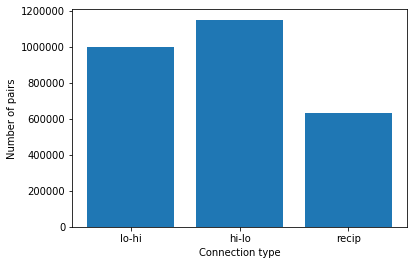

In [19]:
# plt.bar(range(4), pair_motifs)
plt.bar([1,2,3], pair_motifs[1:])
plt.xticks([1,2,3],labels=["lo-hi","hi-lo","recip"])
plt.xlabel("Connection type")
plt.ylabel("Number of pairs")

As expected, the graph is pretty sparse so the vast majority of pairs are disconnected (notice that the first entry in `pair_motifs` is a different scale of magnitude than the rest). So, the plot above only shows the counts for the pairs that are connected. The labels "lo-hi" and "hi-lo" refer to pairs of cells with only a one-way connection, separated by whether the arrow points from the lower ID# to the higher ID# or vice-versa. Since the labels should be essentially arbitrary, any discrepancy (if it's even significant) is an artifact of the labeling process, and not scientifically interesting.

Also, there's no real reason to split up one-way arrows this way, except in the behind-the-scenes of the algorithm. What we're really interested in is, how many pairs of neurons synapse unidirectionally vs. reciprocally? And can we see it a little more clearly in the labels on the x axis? See below:

In [83]:
def pair_motif_graphic(M, graph_x_value, xybox=(0,-5)):
    """Takes adjacency matrix M for a 2-node directed graph and returns a graphic suitable for x tick labels.
    
    Returns an AnnotationBbox object."""
    da = DrawingArea(40, 20, 20, 10)
    circle_1 = mpatches.Circle((-20,0), 10)
    circle_2 = mpatches.Circle((20,0), 10)
    r_arrow = mpatches.Arrow(-20, 5, 30, 0, width=10)
    l_arrow = mpatches.Arrow(20, -5, -30, 0, width=10)
    if M[0,1]:
        da.add_artist(r_arrow)
    if M[1,0]:
        da.add_artist(l_arrow)
    da.add_artist(circle_1)
    da.add_artist(circle_2)
    
    motif_ab = AnnotationBbox(da, (graph_x_value, 0),
                             xybox=(0,-5),
                             xycoords=("data","axes fraction"),
                             box_alignment=(0.5,1),
                             boxcoords="offset points",
                             bboxprops={"edgecolor" : "none"})
    return motif_ab


def triplet_motif_graphic(M,graph_x_value, xybox=(0,-5), circle_radius=10, arrow_width=10):
    da = DrawingArea(40, 60, 20, 30)
    circle_0 = mpatches.Circle((-20,0), circle_radius)
    circle_1 = mpatches.Circle((20,0), circle_radius)
    circle_2 = mpatches.Cirlce((0,34), circle_radius)
    arrow_01 = mpatches.Arrow(-20, 5, 20, 0, width=arrow_width)
    arrow_10 = mpatches.Arrow(20, -5, -20, 0, width=arrow_width)
    arrow_02 = mpatches.Arrow(-24, 2, 14, 23, width=arrow_width)
    arrow_20 = mpatches.Arrow(4, 32, -14, -23, width=arrow_width)
    arrow_12 = mpatches.Arrow(16, -2, -14, 23, width=arrow_width)
    arrow_21 = mpatches.Arrow(4, 36, 14, -23, width=arrow_width)
    if M[0,1]:
        da.add_artist(arrow_01)
    if M[0,2]:
        da.add_artist(arrow_02)
    if M[1,0]:
        da.add_artist(arrow_10)
    if M[1,2]:
        da.add_artist(arrow_12)
    if M[2,0]:
        da.add_artist(arrow_20)
    if M[2,1]:
        da.add_artist(arrow_21)
    da.add_artist(circle_0)
    da.add_artist(circle_1)
    da.add_artist(circle_2)
    
    motif_ab = AnnotationBbox(da, (graph_x_value, 0),
                             xybox=(0,-5),
                             xycoords=("data","axes fraction"),
                             box_alignment=(0.5,1),
                             boxcoords="offset points",
                             bboxprops={"edgecolor" : "none"})
    return motif_ab
        

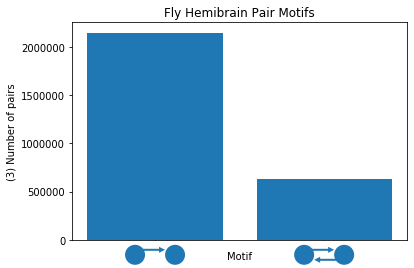

In [85]:
import matplotlib.patches as mpatches
from matplotlib.offsetbox import DrawingArea, OffsetImage, AnnotationBbox

n_edges = nx.number_of_edges(FlyBrain)
n_pairs = n_nodes * (n_nodes - 1) // 2

# The second answer from stackoverflow:
fig, ax = plt.subplots()
# Option 1: Normalize by number of pairs
# ax.bar([1,2], [(pair_motifs[1] + pair_motifs[2]) / n_pairs, pair_motifs[3] / n_pairs])
# plt.ylabel("(1) Fraction of pairs")

# Option 2: Normalize by number of edges. In this case, double count reciprocal connections
# ax.bar([1,2], [(pair_motifs[1] + pair_motifs[2]) / n_edges, 2 * pair_motifs[3] / n_edges])
# plt.ylabel("(2) Fraction of edges")

# Option 3: Unnormalized (just the counts)
ax.bar([1,2], [(pair_motifs[1] + pair_motifs[2]), pair_motifs[3]])
plt.ylabel("(3) Number of pairs")

plt.xlabel("Motif")
plt.title("Fly Hemibrain Pair Motifs")

ax.get_xaxis().set_ticks([1,2])
ax.get_xaxis().set_ticklabels([])

# one-way arrow motif graphic:
ax.add_artist(pair_motif_graphic(np.array([[0,1],[0,0]]), 1))

# two-way arrow motif graphic:
ax.add_artist(pair_motif_graphic(np.array([[0,1],[1,0]]), 2))

The number in parentheses on the y-axis lable specifies which option was used in the code above:

**Option 1:** fraction of pairs of neurons that have the given connection motif.

**Option 2:** fraction of edges that connect a pair of neurons with the given connectivity motif. Notice that in this case we count recipricol pairs twice, since two edges participate per pair.

**Option 3:** Same as option 1, but not normalized (just a raw count of pairs of neurons)

In [73]:
def directed_triplet_motif_index(G):
    """Return the directed motif index of three-node graph G.
    
    The motif index is then computed as follows:
    Each possible (undirected) edge on the nodes of G is sorted in lexicographic order.
    For each pair of vertices, two bits encode, in order, the presence of the edge from
    lower index to higher index and the edge from higher index to lower index. These bits
    are reversed and concatenated to form a single integer
    
    Example: G has three nodes, labeled i,j,k in sorted order. It has edge ij, ik, ki, and kj.
    The lex order for the pairs is ij, ik, jk. Pair ij has edge ij (low-high) but not ji (high-low),
    so the least significant bit is 1 and the second-least significant bit is 0. For pair ik, we have both
    directed edges so those bits are 11. Lastly, pair jk has only the high-low edge, so the higher-order
    bit is 1 while the lower bit is 0. Putting these bits together from right to left we get 101101,
    which is 45 in decimal.
    
    !!! Note that the order of vertices in G has nothing to do with numerical order!
        See networkx documentation about classes OrderedGraph and OrderedDiGraph.
    
    Returns an integer between 0 and 63 (inclusive)
    """
    bit_selector = np.array([[0,1,4], [2,0,16], [8, 32, 0]])
    return np.sum(bit_selector * nx.to_numpy_matrix(G).astypeype(int))


def binary_digits(n, d):  # numpy-optimized
    """Returns an n x d array of the binary digits of each entry of array n
    Parameters:
        n : array_like
            Integer values to be represented as binary digits
        d : the number of digits; zero padding and/or truncation if necessary
    Returns:
        digits : an n x d binary array; each row is the digits of the corresponding entry of n. Least significant bit has index 0.
    """
    return ((n[:, None] & (1 << np.arange(d))) > 0).astype(int)

def index_to_directed_triplet_motif(n):
    """Return the adjacency matrix corresponding to motif with index n, as defined by the function
    directed_triplet_motif_index"""
    digs = binary_digits(np.array([n]),6)
    A = np.zeros((3,3))
    A[tuple([[0,1,0,2,1,2],[1,0,2,0,2,1]])] = digs
    return A

In [ ]:
# triplet motifs are tricky to count accurately.

triplet_motifs = np.zeros(64)
for e in uFlyBrain.edges:
    # somewhat naive: iterate over union of neighbors of endpoints of e
    for w in nx.node_boundary(uFlyBrain, e):
        motif_index = directed_triplet_motif_index(nx.induced_subgraph(FlyBrain, [e[0],e[1],w]))
        triplet_motifs[motif_index] += 1

# now we need to correct for over-counted motifs:
double_counted = []

## Plots
Let's try some basic plotting

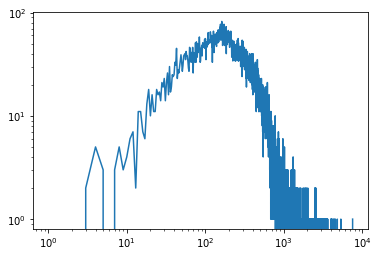

In [3]:
plt.loglog(nx.degree_histogram(FlyBrain))  # degree = in-degree + out-degree, not the most useful

## Notes on counting triplet motifs

A naive algorithm to count the prevalence of triplet motifs would be the following: Since the nodes have ID numbers, they are sorted, so we can consider every triple of the form $(i,j,k)$ with $i < j < k$ and increment the appropriate motif counter. While this is guaranteed to work and count each motif exactly once, it runs in $O(n^3)$ time, where $n$ is the number of nodes in the graph. This takes a long time and ignores two things. The first is the constraint that, if we sum the counts of all the triplet motifs, we should $\binom{n}{3}$, since we are counting each triplet only once -- in particular, this means we can ignore, say, the empty triplets (three nodes with no pairwise connections) since the number of those can be determined from counting all the non-empty triples. The second is that this graph is pretty sparse -- it has about $3 \times 10^6$ edges out of a possible $9 \times 10^8$ possible (directed) edges. So, we'd save a *lot* of time being clever. So, here's a mildly clever algorithm for counting triplet motifs on an undirected graph, which I will then extend to the directed case:

Let $G = ([n],E)$ be an undirected graph on vertex set $[n] := \{1,\ldots,n\}$. For a vertex $u$, let $N(u) = \{v \in [n] : \{u,v\}\in E\}$ denote the neighborhood of $u$. Every edge $e = (u,v)$ partitions the vertices into four sets, which I'll denote $X,U,V,W$. These are, respectively, nodes connected to neither $u$ nor $v$, nodes connected to $u$ only, nodes connected to $v$ only, and nodes connected to both $u$ and $v$. For a given trio of vertices $\{u,v,z\}$, we can determine which of the 7 nonempty motifs we see on those vertices and increment the appropriate counter. The issue is, we will overcount. The partition tells us exactly how often we overcount: For $x \in X$, we will only ever see $\{u,v,x\}$ once. For $u' \in U$, we will count the trio $\{u,u',v\}$ twice: once when we consider edge $e = \{u,v\}$ and once when we consider $e' = \{u,u'\}$. For $v' \in V$ it's the same. For $w \in W$, we will actually see it three times: once when we consider $e = \{u,v\}$, once when we consider $e' = \{u,w\}$, and once when we consider $e'' = \{v,w\}$.

This suggests the following algorithm:

```
Input: G = ([n],E)
Output: motif_counts, the number of occurrences of each triplet motif in G

Initialize motif_counts to zeros

For each edge e of G
    compute the sets U, V, W
    add n - (|U| + |V| + |W| + 2) to motif_counts[one-edge motif]
    add |U|/ 2 + |V| / 2 to motif_counts[two-edge motif]
    add |W| / 3 to motif_counts[three-edge motif]

Set motif_counts[empty motif] = (n choose 3) - sum(other motif counts)

return motif_counts
```
The trickiest part is computing those sets -- this takes time proportional to the size of the neighborhood(s) of $u$ and $v$. So, we end up with an algorithm that takes $O(|E| \cdot \Delta)$ time, where $\Delta$ is the maximum degree of a node in $G$.

To extend this to a directed graph, we actually do the same basic algorithm to the underlying undirected graph:

```
Input: Directed G = ([n],E)
Output: motif_counts, the number of occurrences of each triplet motif in G

Initialize motif_counts to zeros

Set G' = to_undirected(G)

for each edge e of G'
    compute the sets U', V', W' in G'
    add n - (|U| + |V| + |W| + 2) to motif_counts[e's type]
    for u' in U'
        find the induced subgraph on e and u' in G
        increment the corresponding counter
    for v' in V'
        find the induced subgraph on e and v' in G
        increment the corresponding counter
    for w' in W'
        find the induced subgraph on e and w' in G
        increment the corresponding counter

divide the counters corresponding to 2 undirected edge motifs by 2
divide the counters corresponding to 3 undirected edge motifs by 3

return motif_counts
```

Notice that the main difference is, for each undirected motif there correspond several directed motifs, so we have to count a little more carefully.

Combining this with a breadth-first search might speed things up a little more, by letting us manage which neighborhoods need to be computed at any given time.

## Misc scratchwork

In [4]:
FlyBrain.in_degree[5813054846]

223

[(223, 123), (100, 145), (92, 80), (452, 51), (83, 166)]


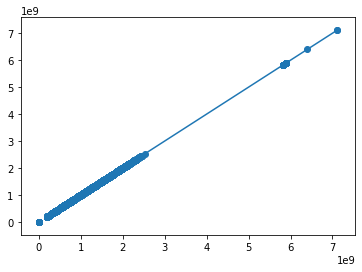

In [63]:
in_out = [(FlyBrain.in_degree[v], FlyBrain.out_degree[v]) for v in FlyBrain.nodes]
print(in_out[:5])
# plt.xscale('log')
# plt.yscale('log')
plt.plot([min(FlyBrain.in_degree),max(FlyBrain.in_degree)], [min(FlyBrain.out_degree), max(FlyBrain.out_degree)])
plt.scatter(FlyBrain.in_degree, FlyBrain.out_degree)

In [12]:
def degrees_by_edges(G, weight_threshold=0, weight_name="weight"):
    """Return an m x 4 numpy array, where m is the number of edges.
    Each row represents a distinct edge, and the columns are (in order):
    pre_in, pre_out, post_in, post_out
    That is, the in-degree and out-degree of the pre- and post-synatpic neuron of each edge.
    
    Ignores edges where edge attribute `weight_name` is strictly less than weight_threshold"""
    pass
## Poking around in the networkx docs has revealed this function is already implemented, here: 